In [35]:
import pandas as pd
import numpy as np
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
yf.pdr_override()
from datetime import datetime
import statsmodels
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
import data_util

In [36]:
i_stocks=data_util.stock_data('INFY',4,'Infosys')
# plot(apple_stocks,'Apple')  

[*********************100%%**********************]  1 of 1 completed


In [37]:
stocks = i_stocks[['Close']].copy()

### We First do the Augmented Dickey Fuller Test to check the Stationarity of the Data


In [38]:
test_Results=adfuller(stocks["Close"])
print("p-value of the Test",test_Results[1])

p-value of the Test 0.05731462778111136


#### Since the p-value is large , we conclude that the data is not stationary. We take the difference and again do the ADS test .

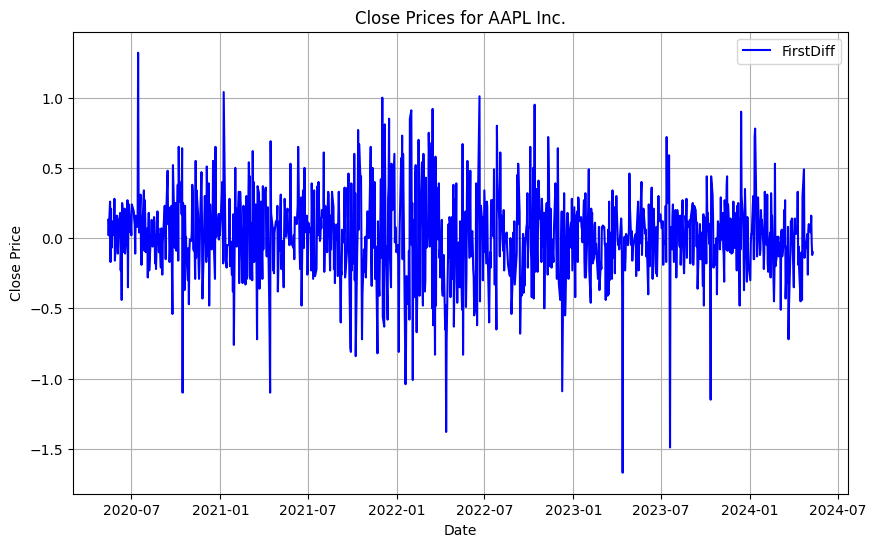

In [39]:
stocks['FirstDiff'] = stocks['Close'].diff().dropna()
plt.figure(figsize=(10, 6))
plt.plot(stocks.index, stocks['FirstDiff'], color='blue', label='FirstDiff')
plt.title(f'Close Prices for {"AAPL"} Inc.')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()  
plt.grid(True)
plt.show()

In [40]:
test_Results=adfuller(stocks["FirstDiff"][1:])#first entry will be Nan
print("p-value of the Test",test_Results[1])

p-value of the Test 0.0


#### On taking the first difference we get the p-value as low as 0.00 , thus we conclude the first diffeernce data is stationary . This can be further be confirmed by using ndiff function in pmdarima library.

In [41]:
from pmdarima.arima.utils import ndiffs

d = ndiffs(stocks["Close"])

print("No. of differences needed:", d)

No. of differences needed: 1


#### Now we plot AutoCorrelation Function(ACF) and Partial AutoCorrelation Function(PACF) to determing the order of ARIMA model.

<BarContainer object of 30 artists>

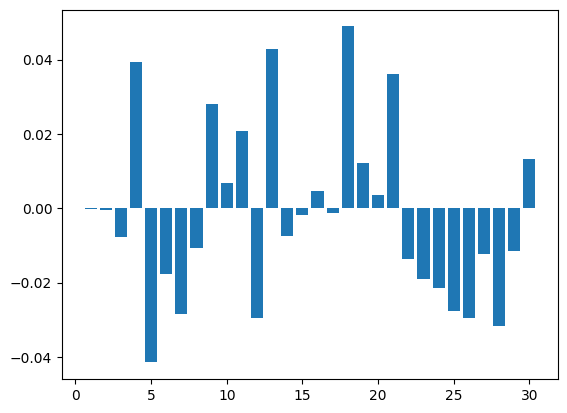

In [42]:
acf_vals = acf(stocks['FirstDiff'][1:])
plt.bar(range(1,acf_vals.shape[0]), acf_vals[1:acf_vals.shape[0]])
# acf_vals.shape

<BarContainer object of 30 artists>

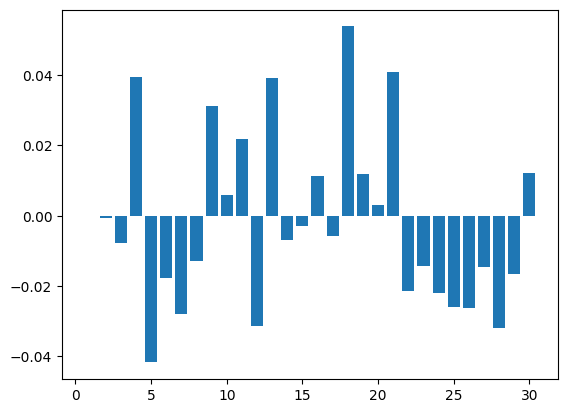

In [43]:
pacf_vals = pacf(stocks['FirstDiff'][1:])
plt.bar(range(1,pacf_vals.shape[0]), pacf_vals[1:pacf_vals.shape[0]])

In [44]:
train=pd.DataFrame(stocks['Close'][0:int(len(stocks)*0.70)])
test=pd.DataFrame(stocks['Close'][int(len(stocks)*0.70):])


In [45]:
from statsmodels.tsa.arima.model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(train, order=(5,1,5))
# model = ARIMA(stocks['FirstDiff'][1:], order=(2,0,2))

model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  704
Model:                 ARIMA(5, 1, 5)   Log Likelihood                -229.132
Date:                Mon, 13 May 2024   AIC                            480.265
Time:                        05:32:41   BIC                            530.374
Sample:                             0   HQIC                           499.631
                                - 704                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4097      0.466      0.880      0.379      -0.503       1.322
ar.L2          0.8471      0.260      3.262      0.001       0.338       1.356
ar.L3         -0.8752      0.158     -5.522      0.0

(array([0.01041346, 0.02603366, 0.1301683 , 0.39050491, 1.08820703,
        1.27564939, 0.49984629, 0.19785582, 0.03644713, 0.00520673]),
 array([-1.38637211, -1.1131729 , -0.83997369, -0.56677448, -0.29357528,
        -0.02037607,  0.25282314,  0.52602235,  0.79922155,  1.07242076,
         1.34561997]),
 <BarContainer object of 10 artists>)

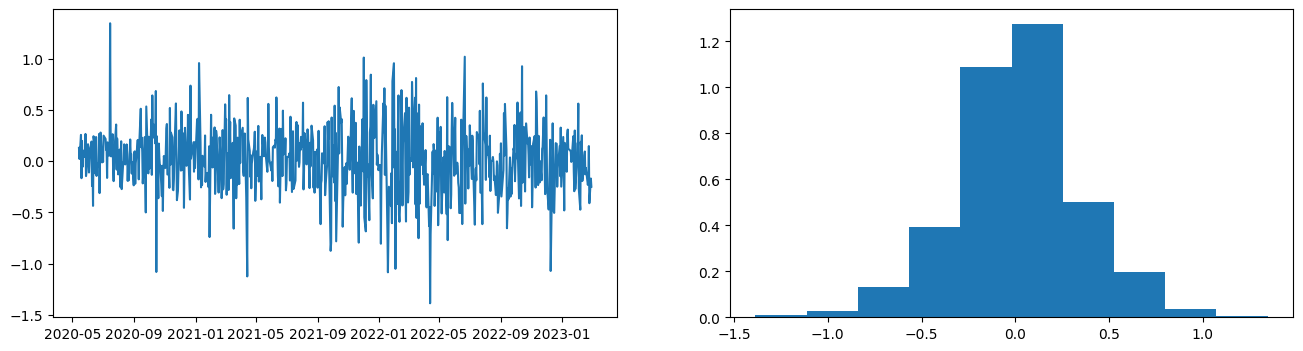

In [46]:
residuals = pd.DataFrame(model_fit.resid[1:])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(residuals)

ax2.hist(residuals, density=True)

In [47]:
predictions = model_fit.forecast(len(test))

dates = test.index.tolist()  # Convert index to list of dates
predictions = predictions.tolist()  # Convert predicted values to list

# Create a DataFrame using the lists of dates and predictions
predicted_df = pd.DataFrame({'Predicted_Value': predictions}, index=dates)

# Print the DataFrame
print(predicted_df)



            Predicted_Value
2023-03-01        17.963426
2023-03-02        17.906815
2023-03-03        17.925294
2023-03-06        17.854217
2023-03-07        17.913669
...                     ...
2024-05-06        17.951575
2024-05-07        17.952656
2024-05-08        17.953273
2024-05-09        17.953042
2024-05-10        17.952053

[302 rows x 1 columns]


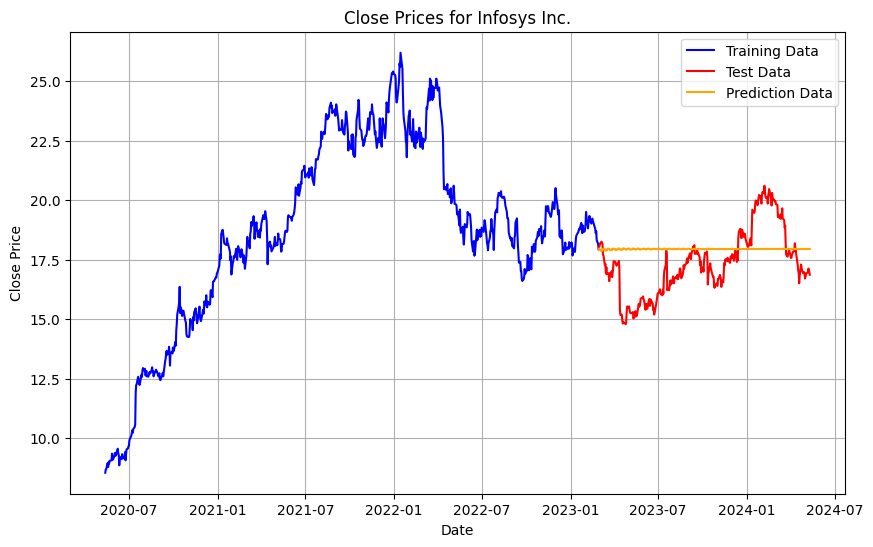

In [48]:
plt.figure(figsize=(10, 6))

# Plot training data
plt.plot(train.index, train, color='blue', label='Training Data')

# Plot test data
plt.plot(test.index, test, color='red', label='Test Data')
plt.plot(predicted_df.index, predicted_df, color='orange', label='Prediction Data')

plt.title('Close Prices for Infosys Inc.')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


## Rolling Forecast Origin

In [49]:

import warnings
warnings.filterwarnings("ignore")
rolling=int(len(stocks)*0.70)
train=pd.DataFrame(stocks['Close'][0:rolling])
test=pd.DataFrame(stocks['Close'][rolling:])
predictions_rolling=[]
for i in range(len(test)):
    try:
        model = ARIMA(train, order=(5,1,5))
        model_fit = model.fit()
        pred=model_fit.forecast()
        predictions_rolling.append(pred)
        print(float(pred),test['Close'][i])
    except:
        predictions_rolling.append(stocks['Close'][rolling])
        print("Singular Matrix found")
    rolling+=1
    train=pd.DataFrame(stocks['Close'][0:rolling])
print(predictions_rolling)

17.963425822356797 18.020000457763672
17.963154773291485 18.09000015258789
18.09566365170237 18.18000030517578
18.108122789698093 18.260000228881836
18.306596311161982 18.219999313354492
18.242261096628265 18.15999984741211
18.1909521761801 17.719999313354492
17.739316370432935 17.68000030517578
17.62664542269132 17.270000457763672
17.238502500093432 17.329999923706055
17.24827553402993 16.93000030517578
16.982851903438537 17.190000534057617
17.17438104399052 16.889999389648438
16.9991088999095 16.93000030517578
16.901235630299112 16.889999389648438
16.896350272692597 16.600000381469727
16.542326632230477 16.940000534057617
16.901650861985605 16.799999237060547
16.800362854034322 17.020000457763672
16.99107640513545 16.770000457763672
16.82107436818902 16.959999084472656
16.955515670400022 17.139999389648438
17.187381570753246 17.440000534057617
17.363995318273716 17.420000076293945
17.3916581850424 17.3700008392334
17.37778595577649 17.329999923706055
17.307730713161565 17.25
17.33275

In [55]:
predictions_rolling=[float(i) for i in predictions_rolling]

In [56]:

dates = test.index.tolist()

rolling_predicted_df = pd.DataFrame({'Predicted_Value': predictions_rolling}, index=dates)

# Print the DataFrame
print(rolling_predicted_df)


            Predicted_Value
2023-03-01        17.963426
2023-03-02        17.963155
2023-03-03        18.095664
2023-03-06        18.108123
2023-03-07        18.306596
...                     ...
2024-05-06        16.942530
2024-05-07        16.998677
2024-05-08        17.160251
2024-05-09        17.142273
2024-05-10        16.941773

[302 rows x 1 columns]


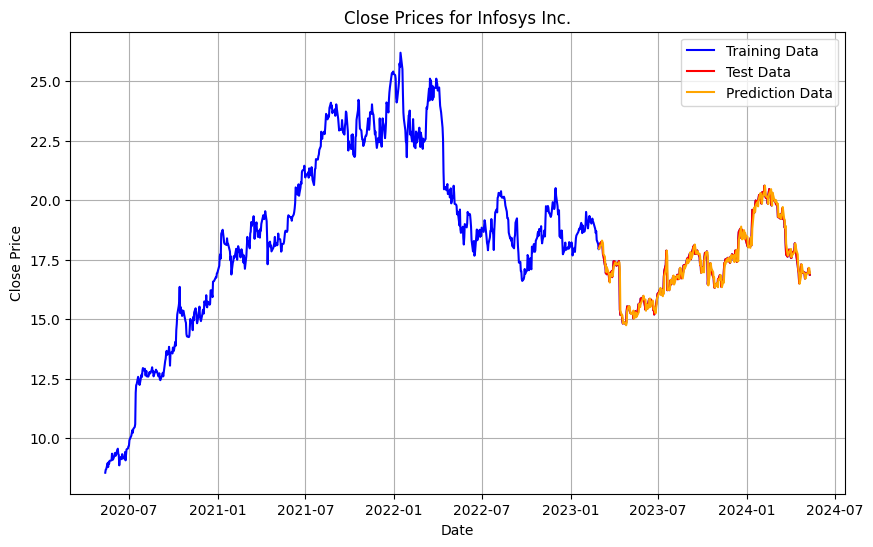

In [57]:
plt.figure(figsize=(10, 6))

# Plot training data
plt.plot(train.index, train, color='blue', label='Training Data')

# Plot test data
plt.plot(test.index, test, color='red', label='Test Data')
plt.plot(rolling_predicted_df.index, rolling_predicted_df, color='orange', label='Prediction Data')

plt.title('Close Prices for Infosys Inc.')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


In [58]:
from Evaluation_metrics import *
def evaluate_metrics(y_true, y_pred):
    results = {
        'Metric': ['MAPE', 'MAE', 'MSE', 'RMSE', 'R2', 'SMAPE'],
        'Value': [MAPE(y_true, y_pred), 
                  MAE(y_true, y_pred), 
                  MSE(y_true, y_pred), 
                  RMSE(y_true, y_pred), 
                  R2(y_true, y_pred), 
                  SMAPE(y_true, y_pred)]
    }
    df = pd.DataFrame(results)
    
    # Add dotted lines
    dotted_style = [dict(selector="th", props=[("border-bottom", "1px dotted #aaaaaa")]),
                    dict(selector="td", props=[("border-bottom", "1px dotted #aaaaaa")])]
    
    # Apply styling
    styled_df = (df.style
                 .set_properties(**{'text-align': 'center'})
                 .format({'Value': '{:.2f}'})  # Round values to 2 decimal places
                 .set_table_styles(dotted_style)
                 .set_caption('Evaluation Metrics')
                 .set_table_attributes('style="border-collapse: collapse; border: none;"')
                 .set_properties(subset=['Metric'], **{'font-weight': 'bold',}))  # Bold and blue headers
    
    return styled_df

In [59]:
y_true=test["Close"].values
y_pred=rolling_predicted_df["Predicted_Value"].values
styled_df = evaluate_metrics(y_true, y_pred)
styled_df

,Metric,Value
0,MAPE,1.07
1,MAE,0.18
2,MSE,0.07
3,RMSE,0.27
4,R2,0.96
5,SMAPE,1.06
